In [1]:
CSV_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

In [2]:
import pickle
import pandas as pd
import numpy as np
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

In [3]:
results_df = pickle.load(open(CSV_PATH  + 'results_df.pickle', 'rb'))

In [4]:
#results_df = results_df.iloc[0:1000000]

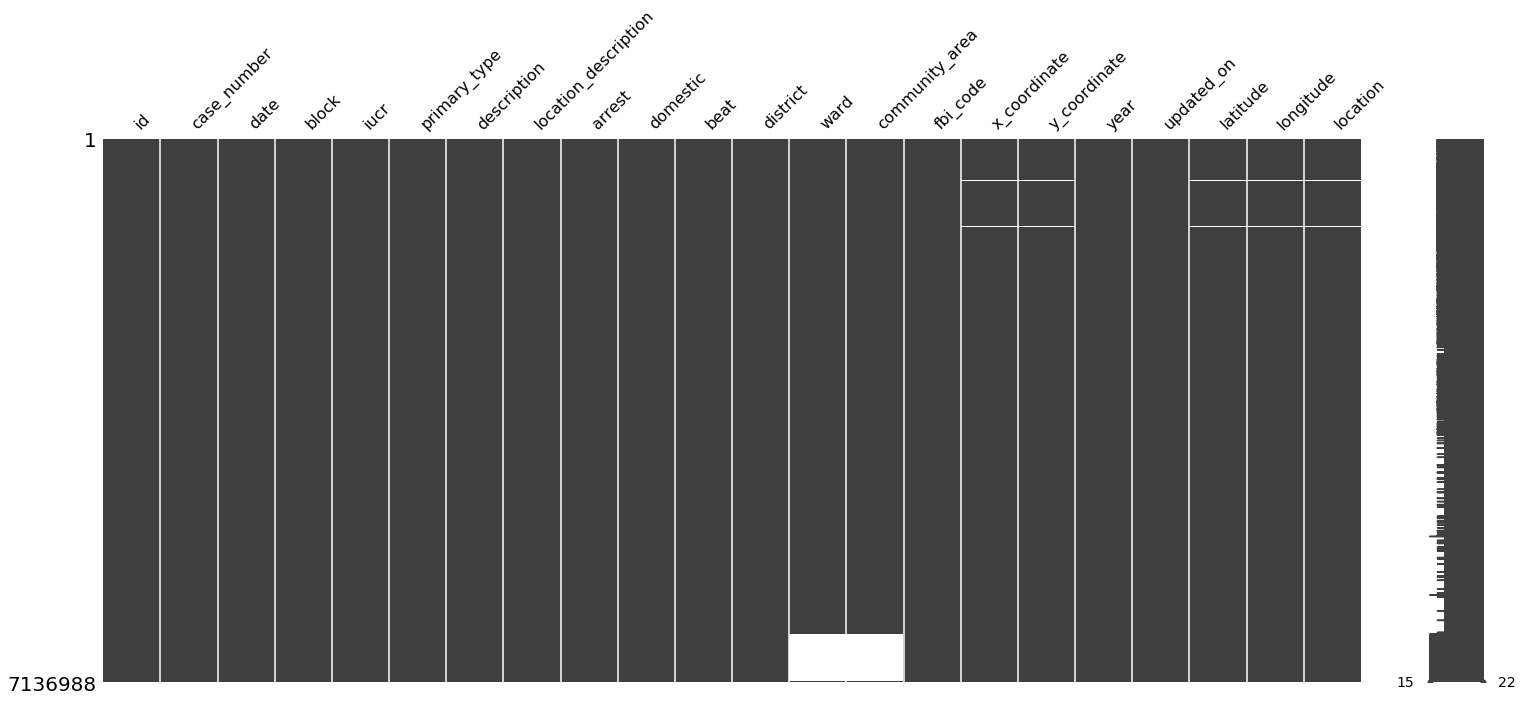

In [4]:
#plot missing variables list
import matplotlib.pyplot as plt
import missingno as msno
msno.matrix(results_df)
plt.show()

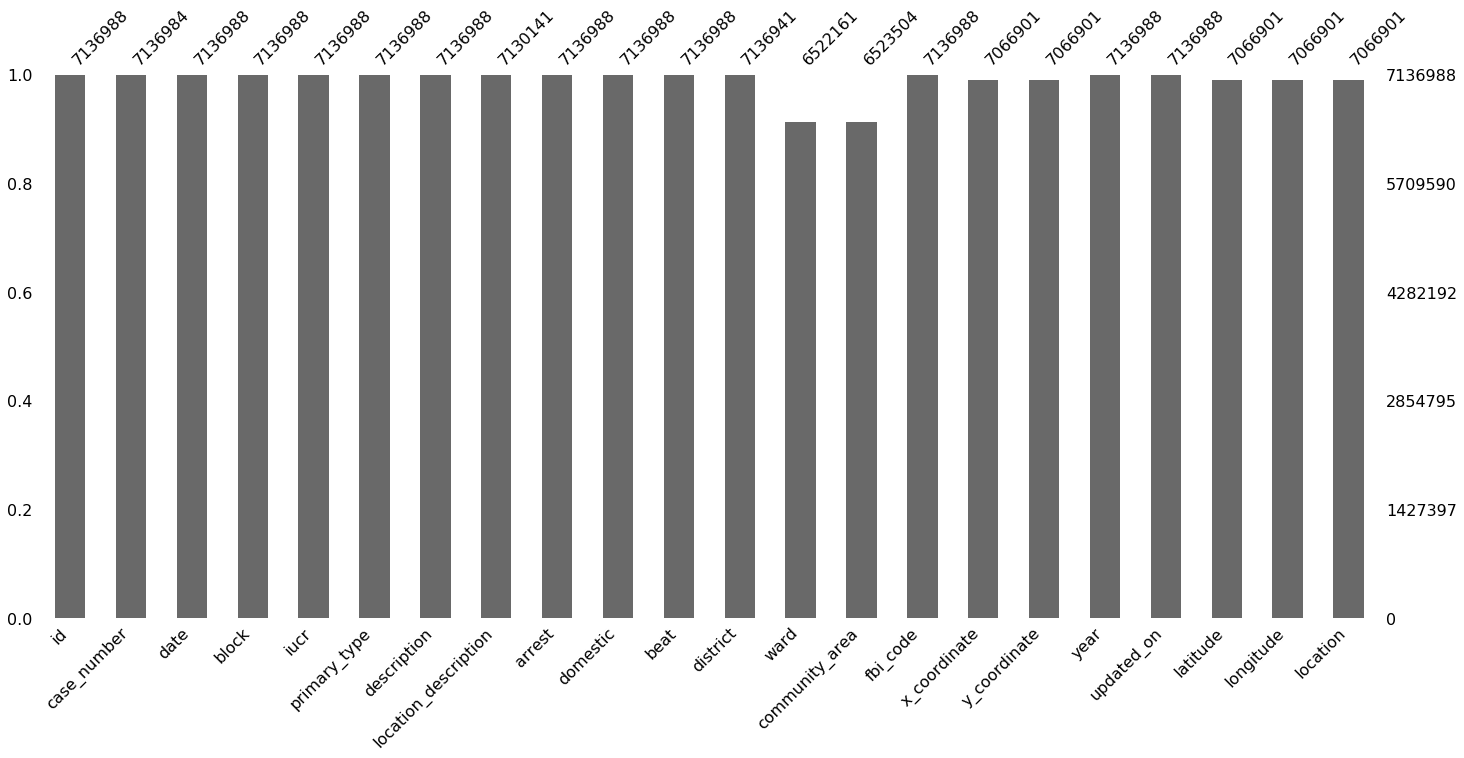

In [5]:
msno.bar(results_df) 

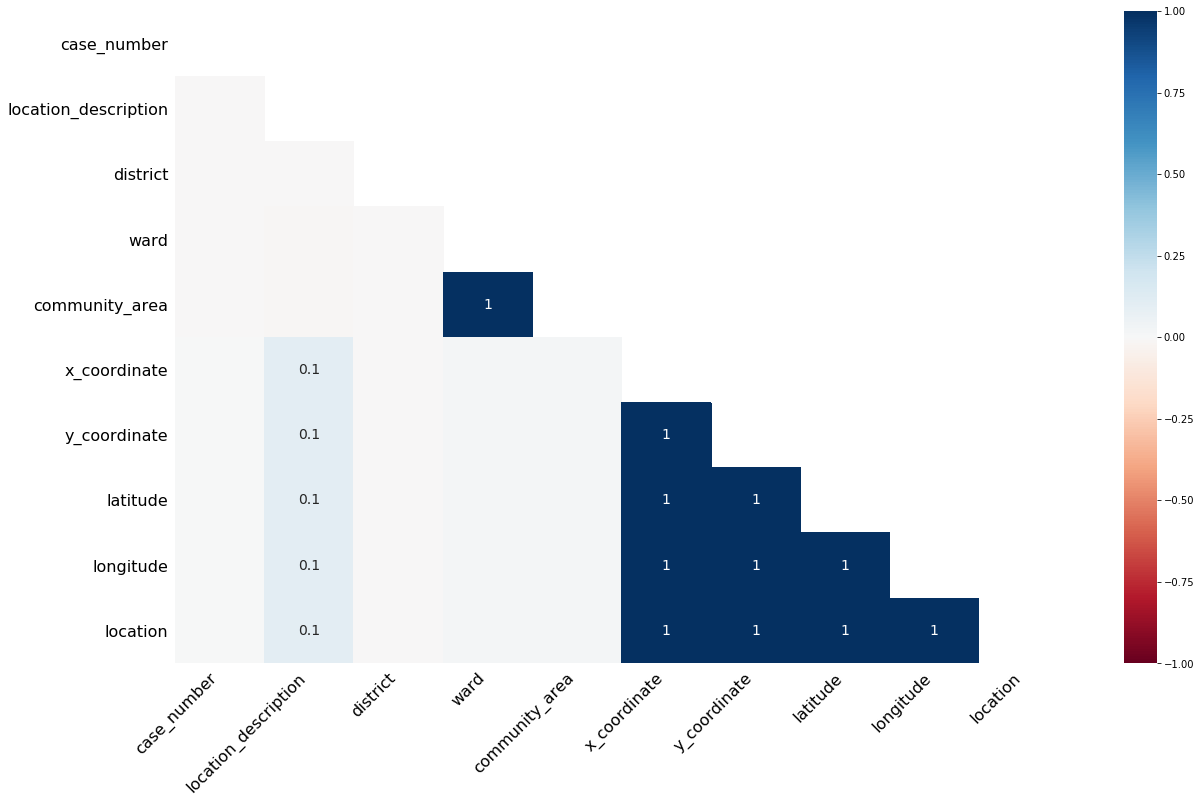

In [6]:
msno.heatmap(results_df) 

In [7]:
results_df.primary_type.value_counts()

THEFT                                1508340
BATTERY                              1306042
CRIMINAL DAMAGE                       812210
NARCOTICS                             731312
ASSAULT                               449266
OTHER OFFENSE                         443339
BURGLARY                              403274
MOTOR VEHICLE THEFT                   328306
DECEPTIVE PRACTICE                    292360
ROBBERY                               268040
CRIMINAL TRESPASS                     203172
WEAPONS VIOLATION                      80823
PROSTITUTION                           69207
PUBLIC PEACE VIOLATION                 50195
OFFENSE INVOLVING CHILDREN             49203
CRIM SEXUAL ASSAULT                    28572
SEX OFFENSE                            27137
INTERFERENCE WITH PUBLIC OFFICER       17230
GAMBLING                               14580
LIQUOR LAW VIOLATION                   14366
ARSON                                  11810
HOMICIDE                               10319
KIDNAPPING

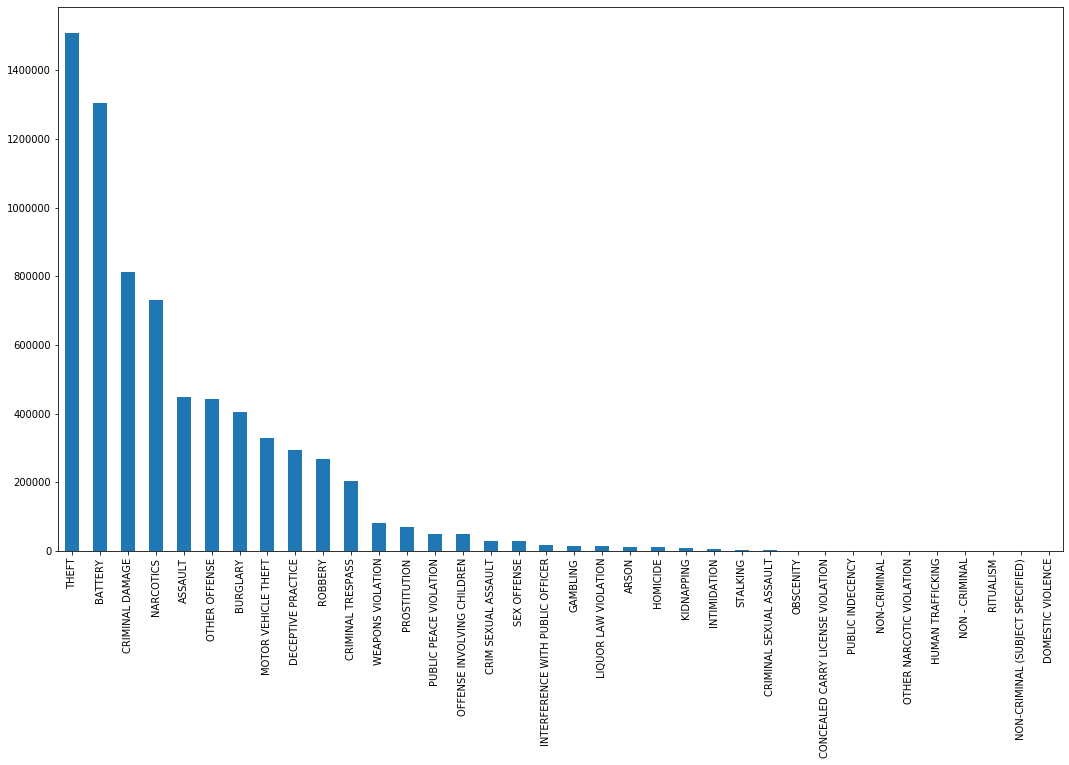

In [8]:
results_df.primary_type.value_counts().plot.bar(figsize=(18,10))

In [9]:
print(max(results_df.date))
print(min(results_df.date))

2020-06-12T23:40:00.000
2001-01-01T00:00:00.000


#### Chicago City Bound

In [10]:
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)

In [11]:
test_df = results_df
test_df = test_df[test_df.latitude.notna()].sort_values(['date'], ascending=[0])
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['updated_on'] = pd.to_datetime(test_df['updated_on'])
test_df['latitude'] = pd.to_numeric(test_df['latitude'])
test_df['longitude'] = pd.to_numeric(test_df['longitude'])

df = test_df
df.columns

Index(['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [ ]:
print(max(test_df['latitude']))
print(min(test_df['latitude']))
print(max(test_df['longitude']))
print(min(test_df['longitude']))

In [ ]:
print(max(test_df['date']))
print(min(test_df['date']))

In [ ]:
 df.columns

In [ ]:
map_arr = []
interval_int = 30 #use 30 days data to predict next 7 days
series_range = 7 #days
time_interval = timedelta(days=interval_int)
date_start = min(df['date'])
date_end = max(df['date'])

geo_price_map = df[['date', 'primary_type','latitude', 'longitude']]

"""geo_price_map = df[['id', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location']]"""

In [ ]:
filter1a = pd.to_numeric(geo_price_map['longitude']) > xbound[0]
filter1b = pd.to_numeric(geo_price_map['longitude']) < xbound[1]
filter1c = pd.to_numeric(geo_price_map['latitude']) > ybound[0]
filter1d = pd.to_numeric(geo_price_map['latitude']) < ybound[1]
print("sum of remaining is: " + str(sum(filter1a&filter1b&filter1c&filter1d)))
geo_price_map = geo_price_map[filter1a&filter1b&filter1c&filter1d]

In [ ]:
print(max(geo_price_map['latitude']))
print(min(geo_price_map['latitude']))
print(max(geo_price_map['longitude']))
print(min(geo_price_map['longitude']))

In [ ]:
#crime_2020_gdf = geo_price_map[geo_price_map.date > pd.to_datetime("2020-01-01")]

#### Group data by the windowed interval of 30 days, slide forward in increment of 7 days and aggregate windows into list of dataframes

In [ ]:
for int_cur_date in range(0, (date_end - date_start).days - interval_int, int(series_range)):
#for int_start_date in range(365, 565, interval_int):
    geo_price_map_filtered = geo_price_map[geo_price_map['longitude'].notnull()]
    
    #filter2 = geo_price_map_filtered['REQUEST_DATE'] > (date_start + timedelta(days=int_start_date))
    #filter3 = geo_price_map_filtered['REQUEST_DATE'] <= (date_start + timedelta(days=int_start_date+interval_int))
    
    filter2 = geo_price_map_filtered['date'] > (date_end - timedelta(days=int_cur_date+interval_int))
    filter3 = geo_price_map_filtered['date'] <= (date_end -  timedelta(days=int_cur_date))
    
    print(date_end - timedelta(days=int_cur_date+interval_int))
    print(date_end -  timedelta(days=int_cur_date))
    
    
    geo_price_map_filtered = geo_price_map_filtered.where(filter2 & filter3)
    print("crime count: " + str(geo_price_map_filtered.notnull().sum()))
    
    print("_"*20)
    map_arr.append(geo_price_map_filtered)

#### Reverse list to be earliest data first in the list

In [ ]:
map_arr.reverse()

In [ ]:
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)

In [ ]:
#print last slide of the time aggregated list of dataframe
map_arr[-1][map_arr[-1]['date'].notnull()]

(-87.85041986215067, -87.52523350043245)
(41.65924455069546, 42.019245840973895)


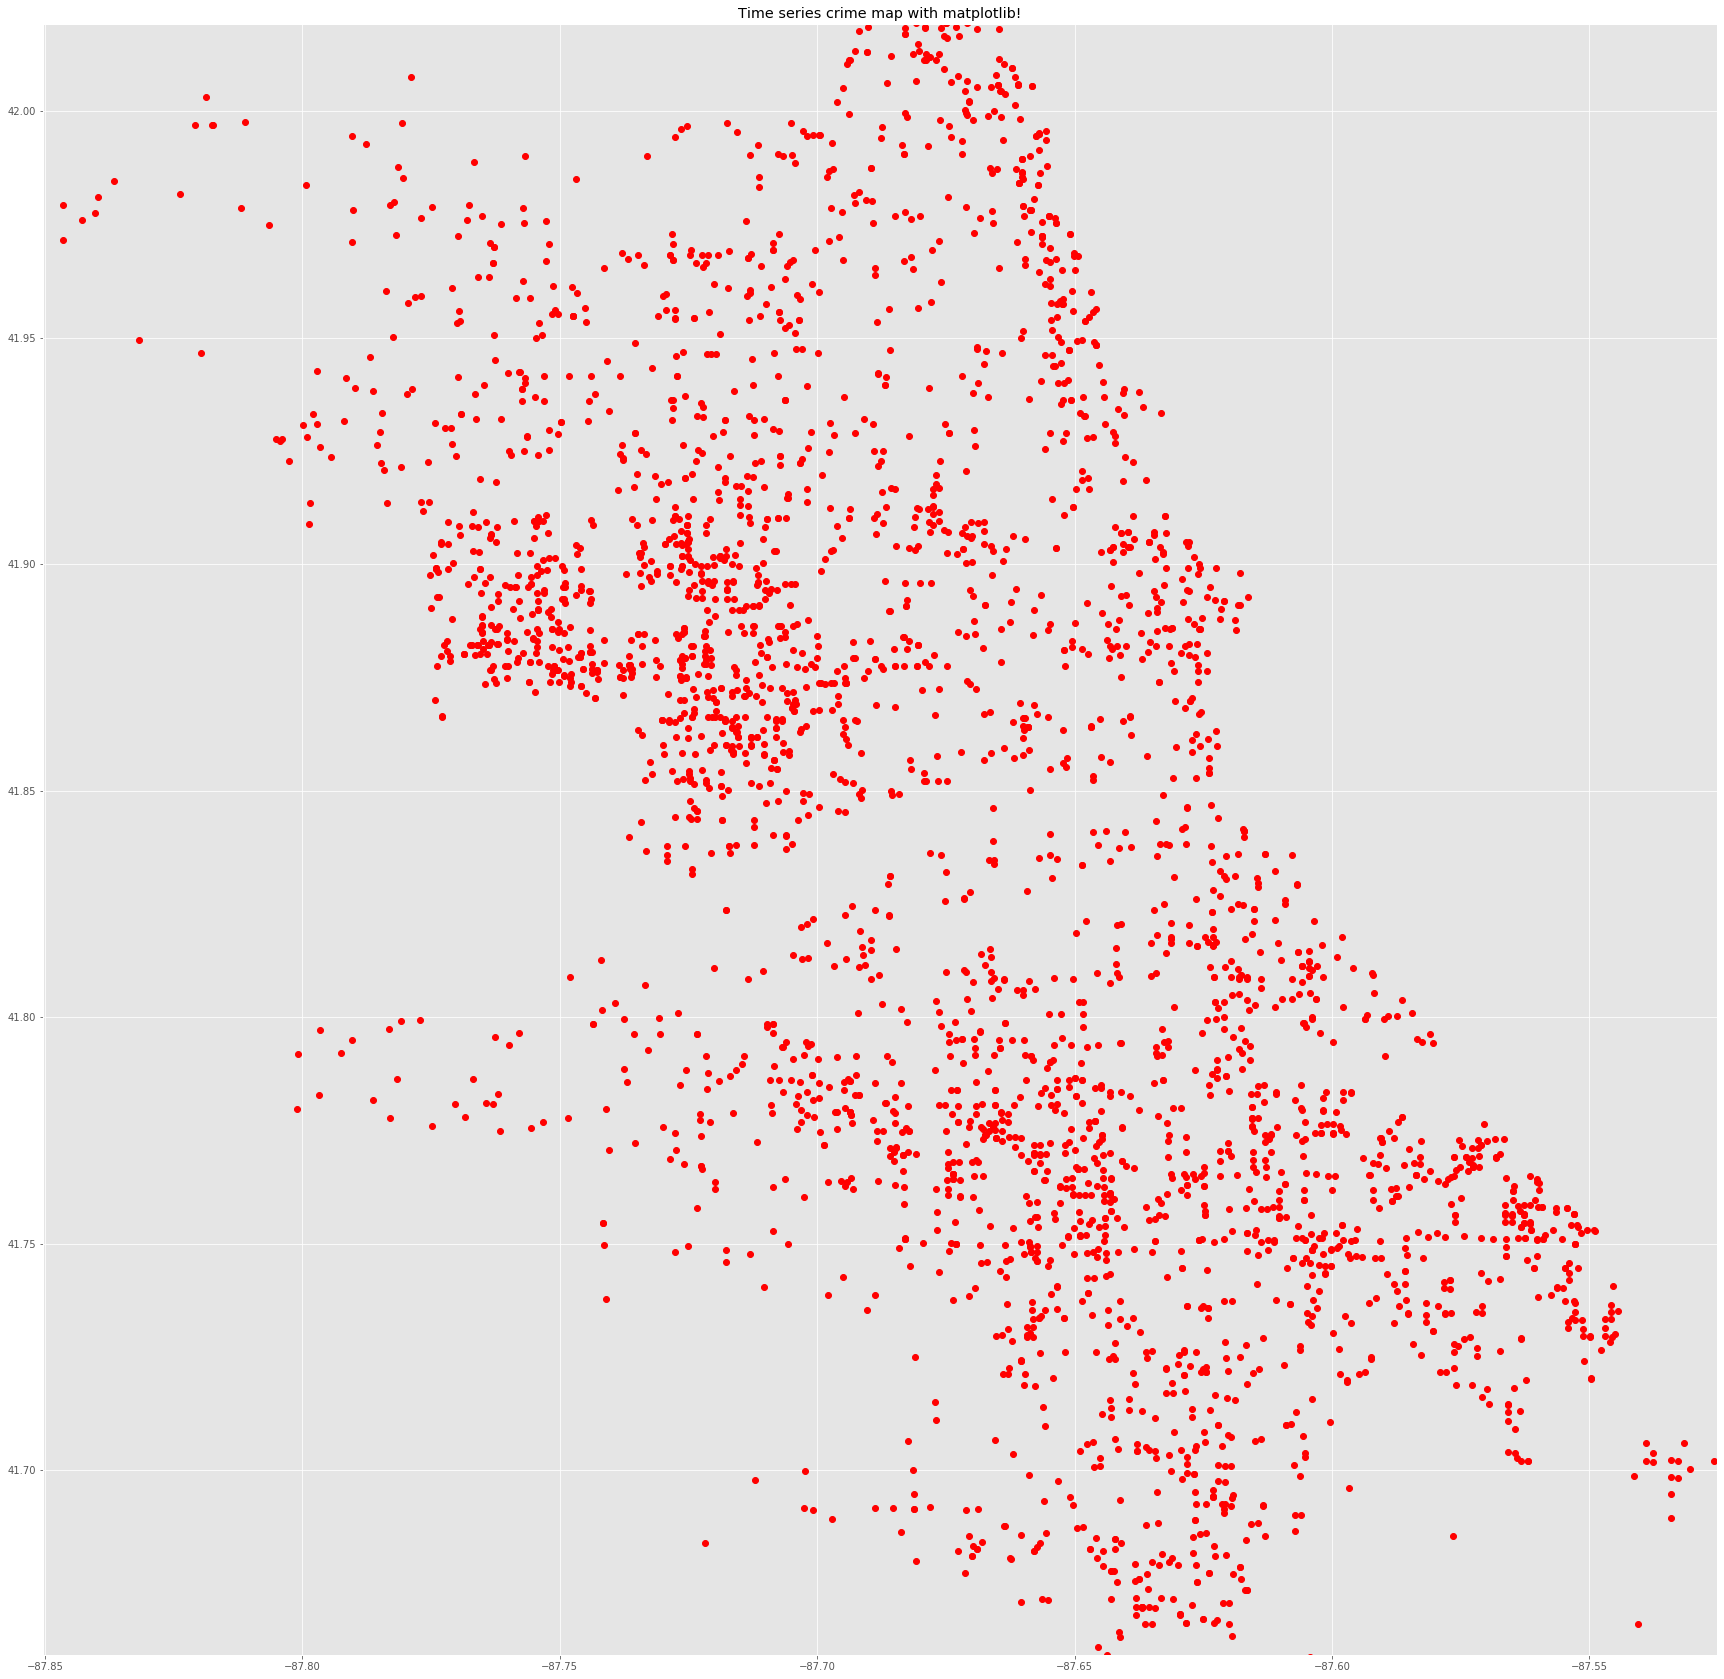

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('ggplot')
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams["figure.figsize"] = [30, 30]

df = map_arr[-1]
xdata = df["longitude"].dropna().to_numpy()
ydata = df["latitude"].dropna().to_numpy()
xlim=(min(xdata), max(xdata)) 
ylim=(min(ydata), max(ydata))


xlim = (-87.85041986215067, -87.52523350043245)
ylim = (41.65924455069546, 42.019245840973895)

print(xlim)
print(ylim)

fig = plt.figure()
#plt.scatter(xdata,ydata)
ax = plt.axes(xlim=xlim, ylim=ylim) 
#ax.set_facecolor((1.0, 0.47, 0.42))
sct, = plt.plot([], [],'o', color='red', lw=2) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    sct.set_data([], [])
    return sct,

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i):
    df = map_arr[i]
    xdata = df["longitude"].dropna().to_numpy()
    ydata = df["latitude"].dropna().to_numpy()
    sct.set_data(xdata,ydata)
    return sct,

# setting a title for the plot 
plt.title('Time series crime map with matplotlib!') 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=np.arange(0,len(map_arr),1), interval=100, blit=True,repeat=False) 

# save the animation as mp4 video file 
anim.save(CSV_PATH + 'crime_locations_2016-2020.gif', writer='imagemagick') 

#### Covert points into geojson and geopandas compatible geometery

In [ ]:
latest_30_df = map_arr[-1][map_arr[-1]['date'].notnull()]
latest_30_df.head()

In [ ]:
from scipy import stats as st
from scipy.stats import gaussian_kde as gaussian_kde
import numpy as np
from KDEpy import FFTKDE, NaiveKDE


def get_kde( x, y, xmin, xmax, ymin, ymax, xx, yy, positions):

    values = np.array([x, y]).T
    #values = values.reshape(values.shape[1], values.shape[0])
    #print("values is: " + str(values))
    #grid, points = get_kernel(values)
    points = get_kernel(values, positions)
    #kernel.set_bandwidth(bw_method=kernel.factor / 30.)
    f = np.reshape(points, xx.shape)
    #print(points.shape)
    #print(grid)
    #return grid, f
    return f

def get_kernel(data, positions):
    #print(data.shape)
    #print(data)
    estimator = FFTKDE(kernel='gaussian', norm=2, bw=0.001)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    points = estimator.fit(data, weights=None).evaluate(positions)
    #grid, points = estimator.fit(data, weights=None).evaluate(grid_size)
    #kernel = gaussian_kde(dataset=values, bw_method="silverman" )
    #return grid, points
    return points

In [ ]:
xbound = (-87.9361,-87.5245)
ybound = (41.6447,42.023)

In [ ]:
grid_size = 25
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
positions = np.dstack([xx.ravel(), yy.ravel()])
positions = positions.reshape(positions.shape[1], positions.shape[2])
grid_matrix = positions

In [ ]:
for i, df in enumerate(map_arr):
    if df["longitude"].count() > 400:
        #grid, points = get_kde(df["LONGITUDE"].dropna().to_numpy(), df["LATITUDE"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        points = get_kde(df["longitude"].dropna().to_numpy(), df["latitude"].dropna().to_numpy() , xmin, xmax, ymin, ymax, xx, yy, positions)
        density_matrix_t_series.append(points)
        print("@" + str(i))

In [ ]:
plt.imshow( X=np.rot90(density_matrix_t_series[-1]), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

In [ ]:
density_matrix_t_series[0].shape

In [ ]:
#This shape is for LSTM model input
#normalized_matrices.shape

In [ ]:
density_matrix_t_series = np.rollaxis(np.dstack(density_matrix_t_series),-1)
density_matrix_t_series.shape

In [ ]:
data2 = density_matrix_t_series
data2.shape

In [ ]:
#data2 = normalized_matrices.reshape((int(normalized_matrices.shape[0]/normalized_matrices.shape[1]), normalized_matrices.shape[1], normalized_matrices.shape[1]))
#data2.shape

In [ ]:
iterable = [np.rot90(matrix) for matrix in data2]

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('ggplot')
mpl.rcParams['agg.path.chunksize'] = 10000

df = map_arr[-1]
xdata = df["longitude"].dropna().to_numpy()
ydata = df["latitude"].dropna().to_numpy()
xlim=(min(xdata), max(xdata)) 
ylim=(min(ydata), max(ydata))

print(xlim)
print(ylim)

plt.rcParams["figure.figsize"] = [30, 30]
fig1, ax1 = plt.subplots()
#ax1.scatter(x="LONGITUDE", y="LATITUDE", data=map_arr[frame_from_latest], c="red", alpha=0.4)
im = plt.imshow( X=iterable[0], cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])


# initialization function 
def init(): 
    # creating an empty plot/frame
    # print("in init")
    im.set_data(iterable[0])
    return [im]


# animation function 
def animate(i):
    #df = map_arr[i]
    #xdata = df["LONGITUDE"].dropna().to_numpy()
    #ydata = df["LATITUDE"].dropna().to_numpy()
    #np.rot90(data2[i])
    #print("in animate")
    im.set_data(iterable[i])
    return [im]

# setting a title for the plot 
plt.title('Time series crime map with matplotlib!') 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig1, animate, init_func=init,frames=np.arange(0,np.rot90(data2).shape[1],1), interval=100, blit=True,repeat=False) 

# save the animation as mp4 video file 
anim.save(CSV_PATH + 'crime_zone.gif', writer='imagemagick') 
plt.show()

(-87.925269164, -87.524618154)
(41.651223603000005, 42.022534793)


In [ ]:
import pickle
pickle.dump( density_matrix_t_series, open( CSV_PATH + "density_matrix_t_series_25x25.pickle", "wb" ) )